In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib widget

# Abbreviations
OMG — optomiography  
ACC — accelerometer  
GYR — gyroscope  
ENC - encoders (fingers of prosthesis or gloves)  
model — model of data  

# Data

In [2]:
gestures_train = pd.read_csv('gestures_train.csv', index_col=0)

print(gestures_train.shape)
gestures_train.head()

(21320, 65)


,0,1,2,3,4,5,6,7,8,9,...,GYR2,ENC0,ENC1,ENC2,ENC3,ENC4,ENC5,BUTTON,SYNC,ts
0,0,0,69,3461,3694,3418,1867,13,7,7,...,-8,13,34,48,35,32,0,0,0,161790
1,0,11,58,3462,3692,3417,1868,13,7,5,...,-1,13,34,48,35,32,0,0,0,161823
2,10,8,51,3463,3693,3418,1870,21,6,6,...,4,13,34,48,35,32,0,0,0,161856
3,11,9,58,3463,3692,3418,1871,13,6,6,...,6,13,34,48,35,32,0,0,0,161889
4,11,8,58,3460,3692,3418,1869,13,6,5,...,7,13,34,48,35,32,0,0,0,161922


In [3]:
# [X features] '0', ..., '49' - каналы OMG датчиков
#              'ACC0', 'ACC1', 'ACC2' - акселерометр (потенциально могут использоваться как факторы для модели)
#              'GYR0', 'GYR1', 'GYR2' - гироскоп     (потенциально могут использоваться как факторы для модели)
# [y target]   'ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5' - координаты пальцев в перчатке GLOVE
# 'BUTTON' - не используется
# 'SYNC' - синхронизация данных с протоколом
# 'ts' - метка времени
gestures_train.columns

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',
       '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36',
       '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48',
       '49', 'ACC0', 'ACC1', 'ACC2', 'GYR0', 'GYR1', 'GYR2', 'ENC0', 'ENC1',
       'ENC2', 'ENC3', 'ENC4', 'ENC5', 'BUTTON', 'SYNC', 'ts'],
      dtype='object')

In [3]:
OMG_CH = [str(i) for i in range(50)]

ACC_CH = ['ACC0', 'ACC1', 'ACC2']
GYR_CH = ['GYR0', 'GYR1', 'GYR2']
# ENC_CH = ['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5']
GLOVE_CH = ['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5']
BUTTON_SYNC_TS_CH = ['BUTTON', 'SYNC', 'ts']

assert len(OMG_CH)+len(ACC_CH)+len(GYR_CH)+len(GLOVE_CH)+len(BUTTON_SYNC_TS_CH) == gestures_train.shape[-1]

print(f"OMG_CH: {list(OMG_CH)}")
print(f"ACC_CH: {list(ACC_CH)}")
print(f"GYR_CH: {list(GYR_CH)}")
print(f"GLOVE_CH: {list(GLOVE_CH)}")
print(f"BUTTON_SYNC_TS_CH: {list(BUTTON_SYNC_TS_CH)}")

OMG_CH: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49']
ACC_CH: ['ACC0', 'ACC1', 'ACC2']
GYR_CH: ['GYR0', 'GYR1', 'GYR2']
GLOVE_CH: ['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5']
BUTTON_SYNC_TS_CH: ['BUTTON', 'SYNC', 'ts']


In [4]:
gestures_test = pd.read_csv('gestures_test.csv', index_col=0)

print(gestures_test.shape)
gestures_test.head()

(5330, 65)


,0,1,2,3,4,5,6,7,8,9,...,GYR2,ENC0,ENC1,ENC2,ENC3,ENC4,ENC5,BUTTON,SYNC,ts
21320,11,19,46,3206,3821,3710,1780,8,5,5,...,-2,12,22,41,83,42,0,0,173,865350
21321,10,8,53,3169,3812,3527,1664,7,5,5,...,-1,12,22,41,83,42,0,0,173,865383
21322,10,7,43,3127,3806,3351,1556,8,6,5,...,4,12,24,45,87,52,0,0,173,865416
21323,10,8,41,3085,3793,3178,1480,7,8,5,...,1,12,24,46,87,55,0,0,173,865449
21324,10,6,48,3046,3771,3049,1436,8,6,6,...,0,12,25,46,88,57,0,0,173,865482


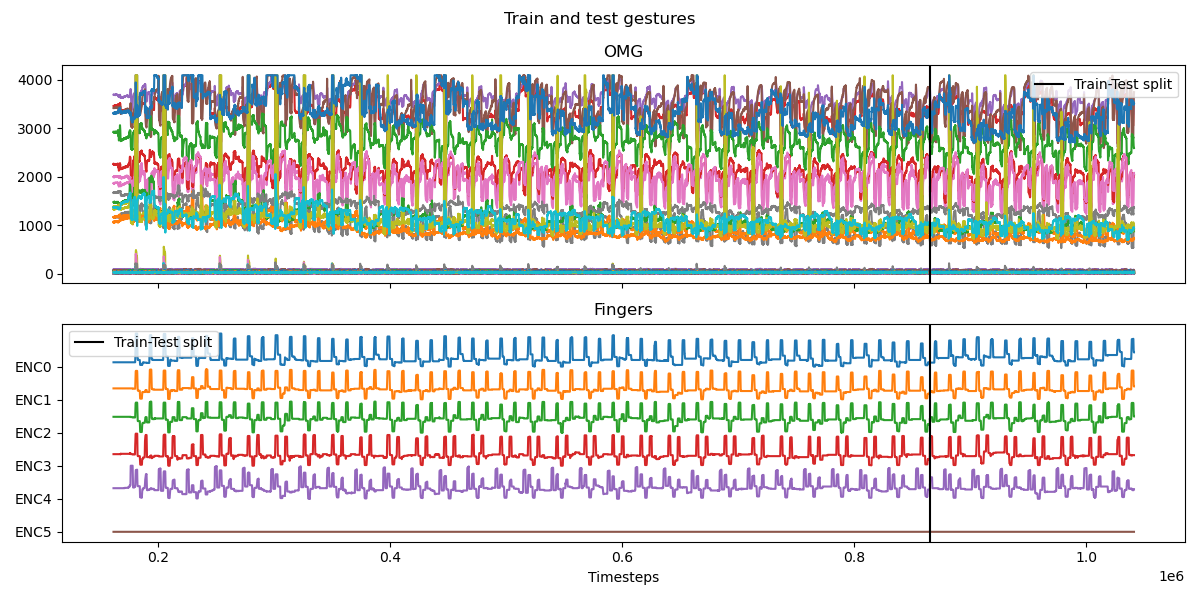

In [5]:
fig, axx = plt.subplots(2, 1, sharex=True, figsize=(12, 6))
plt.sca(axx[0])
plot_train = plt.plot(gestures_train['ts'].values, gestures_train[OMG_CH].values)
plot_test = plt.plot(gestures_test['ts'].values, gestures_test[OMG_CH].values)
for p_train, p_test in zip(plot_train, plot_test):
    p_test.set_color(p_train.get_color())
plt.axvline(gestures_train['ts'].values[-1], color='k', label='Train-Test split')
plt.title('OMG')
plt.legend()

plt.sca(axx[1])
plot_train = plt.plot(gestures_train['ts'].values, gestures_train[GLOVE_CH].values - np.arange(len(GLOVE_CH)) * 100)
plot_test = plt.plot(gestures_test['ts'].values, gestures_test[GLOVE_CH].values - np.arange(len(GLOVE_CH)) * 100)
for p_train, p_test in zip(plot_train, plot_test):
    p_test.set_color(p_train.get_color())
plt.axvline(gestures_train['ts'].values[-1], color='k', label='Train-Test split')
plt.yticks(-np.arange(len(GLOVE_CH)) * 100, GLOVE_CH)
plt.legend()
plt.title('Fingers')
plt.xlabel('Timesteps')

plt.suptitle('Train and test gestures')
plt.tight_layout()

### Protocol

In [6]:
gestures_protocol = pd.read_csv('gestures_protocol.csv')
gestures_protocol.head(10)

,epoch,Thumb,Index,Middle,Ring,Pinky,Thumb_stretch,Index_stretch,Middle_stretch,Ring_stretch,Pinky_stretch,Pronation
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
5,5,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,6,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
7,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5
8,8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5
9,9,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.5


In [7]:
# add OPEN to protocol
mask_open = (gestures_protocol[['Thumb_stretch', 'Index_stretch', 'Middle_stretch', 'Ring_stretch', 'Pinky_stretch']] == 1.0).all(axis=1)
gestures_protocol.loc[mask_open, ['Thumb', 'Index', 'Middle', 'Ring', 'Pinky']] = -0.5

In [8]:
gestures_train_ext = pd.merge(
    gestures_train,
    gestures_protocol,
    how='left',
    left_on='SYNC',
    right_on='epoch',
)

gestures_test_ext = pd.merge(
    gestures_test,
    gestures_protocol,
    how='left',
    left_on='SYNC',
    right_on='epoch',
)

In [9]:
gestures_train_ext.isna().sum().unique(), gestures_test_ext.isna().sum().unique()

(array([0]), array([0]))

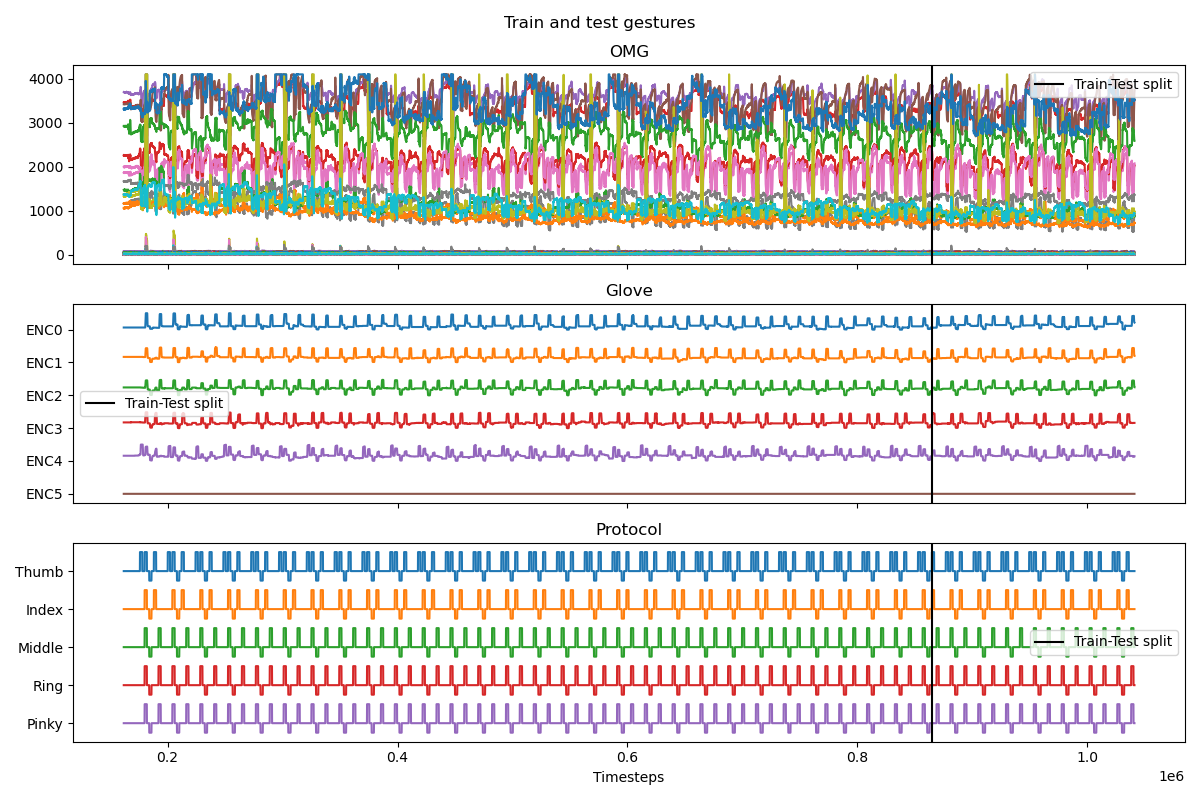

In [10]:
fig, axx = plt.subplots(3, 1, sharex=True, figsize=(12, 8))
plt.sca(axx[0])
plot_train = plt.plot(gestures_train_ext['ts'].values, gestures_train_ext[OMG_CH].values)
plot_test = plt.plot(gestures_test_ext['ts'].values, gestures_test_ext[OMG_CH].values)
for p_train, p_test in zip(plot_train, plot_test):
    p_test.set_color(p_train.get_color())
plt.axvline(gestures_train_ext['ts'].values[-1], color='k', label='Train-Test split')
plt.legend()
plt.title('OMG')

plt.sca(axx[1])
plot_train = plt.plot(gestures_train_ext['ts'].values, gestures_train_ext[GLOVE_CH].values - np.arange(len(GLOVE_CH)) * 200)
plot_test = plt.plot(gestures_test_ext['ts'].values, gestures_test_ext[GLOVE_CH].values - np.arange(len(GLOVE_CH)) * 200)
for p_train, p_test in zip(plot_train, plot_test):
    p_test.set_color(p_train.get_color())
plt.yticks(-np.arange(len(GLOVE_CH)) * 200, GLOVE_CH)
plt.axvline(gestures_train_ext['ts'].values[-1], color='k', label='Train-Test split')
plt.legend()
plt.title('Glove')

plt.sca(axx[2])

plot_train = plt.plot(
    gestures_train_ext['ts'].values,
    gestures_train_ext[['Thumb', 'Index', 'Middle', 'Ring', 'Pinky']].values - np.arange(5) * 2
)

plot_test = plt.plot(
    gestures_test_ext['ts'].values,
    gestures_test_ext[['Thumb', 'Index', 'Middle', 'Ring', 'Pinky']].values - np.arange(5) * 2
)

for p_train, p_test in zip(plot_train, plot_test):
    p_test.set_color(p_train.get_color())
plt.yticks(-np.arange(5) * 2, ['Thumb', 'Index', 'Middle', 'Ring', 'Pinky'])
plt.axvline(gestures_train_ext['ts'].values[-1], color='k', label='Train-Test split')
plt.legend()
plt.xlabel('Timesteps')
plt.title('Protocol')

plt.suptitle('Train and test gestures')
plt.tight_layout()

# Preprocessing

# Modeling

In [11]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

# model = DecisionTreeRegressor()
model = LinearRegression()

model.fit(
    X=gestures_train[OMG_CH].values,
    y=gestures_train[GLOVE_CH].values
)

LinearRegression()

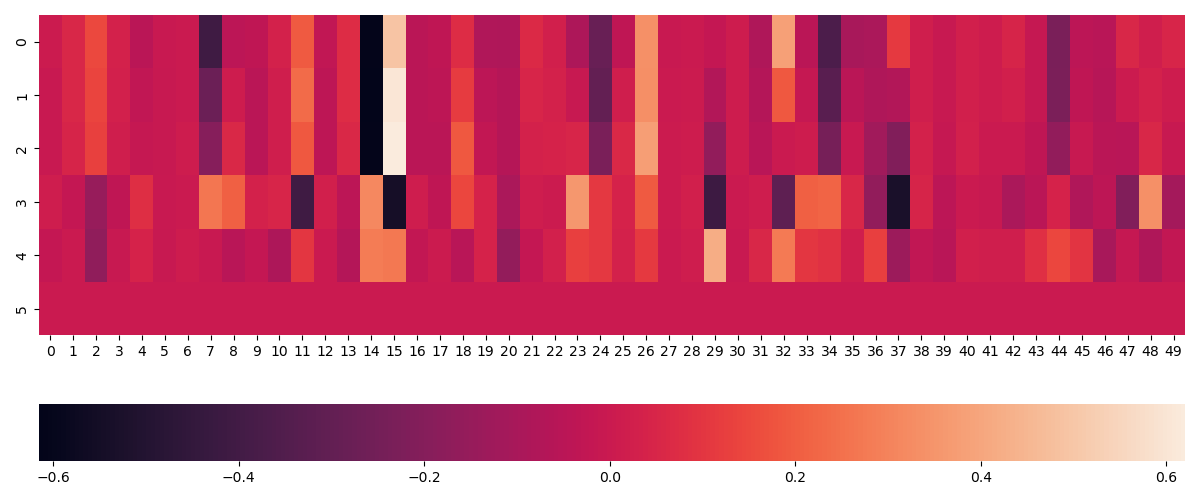

In [12]:
import seaborn as sns

plt.figure(figsize=(12, 5)) # 
sns.heatmap(model.coef_, cbar_kws={"orientation": "horizontal"})
plt.tight_layout()

## Prediction

In [13]:
y_pred_train = model.predict(gestures_train[OMG_CH].values)
y_pred_train = pd.DataFrame(y_pred_train, columns=GLOVE_CH, index=gestures_train['ts'])

y_pred_test = model.predict(gestures_test[OMG_CH].values)
y_pred_test = pd.DataFrame(y_pred_test, columns=GLOVE_CH, index=gestures_test['ts'])

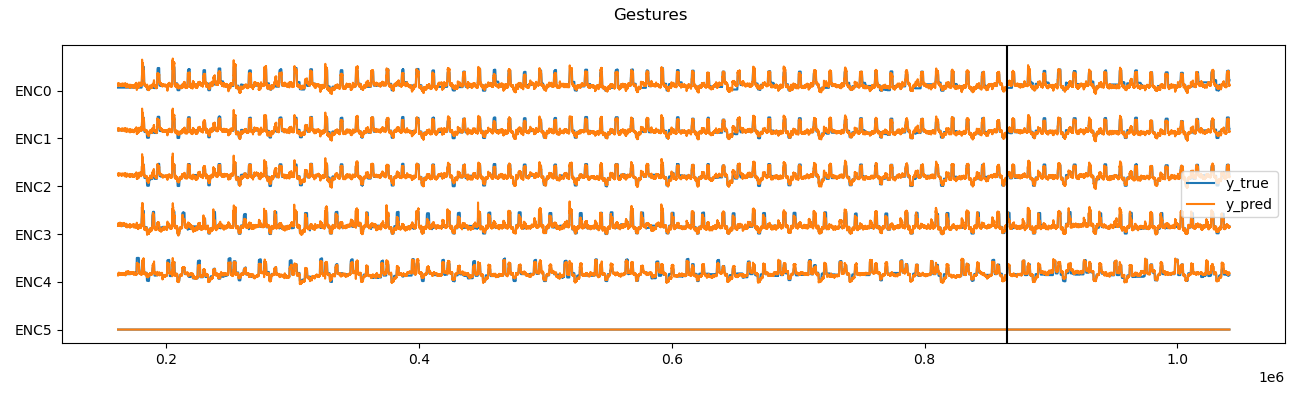

In [14]:
fig, axes = plt.subplots(1, 1, figsize=(13, 4))

plt.sca(axes)
lines = []
labels = []
yticks = -np.arange(len(GLOVE_CH)) * 200

p = plt.plot(gestures_train['ts'].values, gestures_train[GLOVE_CH].values + yticks, c='C0')
plt.plot(gestures_test['ts'].values, gestures_test[GLOVE_CH].values + yticks, c='C0')
lines += [p[0]]
labels += ['y_true']

p = plt.plot(gestures_train['ts'].values, y_pred_train.values + yticks, c='C1', linestyle='-')
plt.plot(gestures_test['ts'].values, y_pred_test.values + yticks, c='C1', linestyle='-')
lines += [p[0]]
labels += ['y_pred']

plt.axvline(gestures_train['ts'].values[-1], color='k')

plt.yticks(yticks, GLOVE_CH)
plt.legend(lines, labels)
plt.suptitle(f'Gestures')
plt.tight_layout()

## Metrics

In [15]:
from sklearn.metrics import mean_squared_error as mse

metrics_train = {col : mse(gestures_train[col], y_pred_train[col]) for col in GLOVE_CH}
metrics_test = {col : mse(gestures_test[col], y_pred_test[col]) for col in GLOVE_CH}

metrics_train = pd.Series(metrics_train)
metrics_test = pd.Series(metrics_test)

print('Train')
display(metrics_train)
print('Test')
display(metrics_test)

Train


ENC0     89.092853
ENC1     59.656244
ENC2     52.899439
ENC3    114.438555
ENC4     64.378662
ENC5      0.000000
dtype: float64

Test


ENC0    104.758887
ENC1     55.782135
ENC2     44.351714
ENC3    117.644508
ENC4     74.007256
ENC5      0.000000
dtype: float64

# Real-time inference

In [16]:
import time
import serial
from IPython.display import clear_output

In [17]:
crc_table = [
    54, 181, 83, 241, 89, 16, 164, 217, 34, 169, 220, 160, 11, 252,
    111, 241, 33, 70, 99, 240, 234, 215, 60, 206, 68, 126, 152, 81,
    113, 187, 14, 21, 164, 172, 251, 16, 248, 215, 236, 90, 49, 53,
    179, 156, 101, 55, 65, 130, 161, 22, 218, 79, 24, 168, 152, 205,
    115, 141, 23, 86, 141, 58, 122, 215, 252, 48, 69, 115, 138, 66,
    88, 37, 63, 104, 176, 46, 139, 246, 222, 184, 103, 92, 154, 174,
    97, 141, 195, 166, 227, 150, 140, 48, 121, 243, 13, 131, 210, 199,
    45, 75, 180, 104, 97, 82, 251, 90, 132, 111, 229, 175, 146, 216,
    153, 86, 166, 33, 184, 100, 225, 248, 186, 54, 89, 39, 2, 214, 2,
    114, 197, 6, 35, 188, 245, 64, 220, 37, 123, 132, 190, 60, 189, 53,
    215, 185, 238, 145, 99, 226, 79, 54, 102, 118, 210, 116, 51, 247,
    0, 191, 42, 45, 2, 132, 106, 52, 63, 159, 229, 157, 78, 165, 50,
    18, 108, 193, 166, 253, 3, 243, 126, 111, 199, 152, 36, 114, 147,
    57, 87, 14, 16, 160, 128, 97, 189, 51, 115, 142, 8, 70, 71, 55, 42,
    193, 65, 207, 122, 158, 26, 21, 72, 139, 33, 230, 230, 116, 134, 5,
    213, 165, 107, 41, 134, 219, 190, 26, 29, 136, 174, 190, 108, 185, 172,
    137, 239, 164, 208, 207, 206, 98, 207, 12, 0, 174, 64, 20, 90, 49, 12,
    67, 112, 109, 78, 114, 165, 244, 183, 121
];
    
def get_crc(data, count):
    result = 0x00
    l = count
    while (count>0):   
        result = crc_table[result ^ data[l-count]]
        count -= 1;
    return result;

def drv_abs_one(ser, control):
    if ser is None:
        return
    pack = (np.array([80, 0x01, 0xBB, 6] + [c for c in control] + [0], dtype='uint8'))
    pack[-1] = get_crc(pack[1:], 9)
    return (pack, ser.write(bytearray(pack)))

## Inference Utils: Put your code here

In [18]:
def preprocessing(x):
    # x - sample vector
    y = x
    return y

def inference(x):
    y = model.predict([x])[0] 
    return y

def postprocessing(x, prev):
    if prev is None:
        y = x
    else:
        y = x*0.1 + prev*0.9 # Holt-Winters filter
    return y

def commands(x):
    y = np.round(np.clip(x / 100, 0, 1)*100).astype(int)
    return y

## Inference

### Offline (dataset)

In [19]:
df_sim = gestures_test.copy()
# df_sim = free_movements.iloc[:10000]
print(df_sim.shape)

(5330, 65)


In [20]:
TIMEOUT = 0.033
DEBUG = False
    
i = 0
ts_old = time.time()
ts_diff = 0;

y_previous = None
y_dct = {
    'omg_sample':[],
    'enc_sample':[],
    'sample_preprocessed':[],
    
    'y_predicted':[],
    'y_postprocessed':[],
    'y_commands':[],
}
while True:    
    
    # [Data reading]
    ts_start = time.time()
    
    try:
        # [Sim data]
        if i < len(df_sim):
            sample = df_sim.values[i]
        else:
            break
        # [/Sim data]
        [omg_sample, acc_sample, enc_sample, [button, sync, ts]] = np.array_split(sample, [50, 56, 62])
        
    except Exception as e:
        print(e)
        
    # [/Data Reading]
        
    # [Data preprocessing]
    sample_preprocessed = preprocessing(omg_sample)
    # [/Data preprocessing]
    
    # [Inference]
    y_predicted         = inference(sample_preprocessed)
    # [/Inference]
    
    # [Inference Postprocessing]
    y_postprocessed     = postprocessing(y_predicted, y_previous)
    # [/Inference Postprocessing]
    
    # [Commands composition]
    y_commands          = commands(y_postprocessed)
    # [/Commands composition]
    
    # [Commands sending]
    # NO COMMANDS SENDING IN SIMULATION
    # [/Commands sending]
    
    # [Data logging]
    y_dct['omg_sample'].append(omg_sample)
    y_dct['enc_sample'].append(enc_sample)
    y_dct['sample_preprocessed'].append(sample_preprocessed)
    y_dct['y_predicted'].append(y_predicted)
    y_dct['y_postprocessed'].append(y_postprocessed)
    y_dct['y_commands'].append(y_commands)
    # [/Data logging]

    y_previous = y_postprocessed
    
    if DEBUG:
        clear_output(wait=True)

        # sanity check: Sizes of SAMPLE=65, OMG=50, ACC=6, ENCODERS=6
        print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}, ACC: {len(acc_sample)}, ENCODERS: {len(enc_sample)}')
        print(f'BUTTON: {button}, SYNC: {sync}, TS: {ts}')
        print(y_commands)
    
    ts_diff = time.time() - ts_start
    assert(ts_diff<TIMEOUT), 'Calculation cycle takes more than TIMEOUT, halting...'
    ts_old = ts_start
    i += 1 

In [21]:
for key, val in y_dct.items():
    # print(f"len({key}) = {len(y_dct[key])}")
    y_dct[key] = np.stack(val)
    print(f"{key}.shape = {y_dct[key].shape}")

omg_sample.shape = (5330, 50)
enc_sample.shape = (5330, 6)
sample_preprocessed.shape = (5330, 50)
y_predicted.shape = (5330, 6)
y_postprocessed.shape = (5330, 6)
y_commands.shape = (5330, 6)


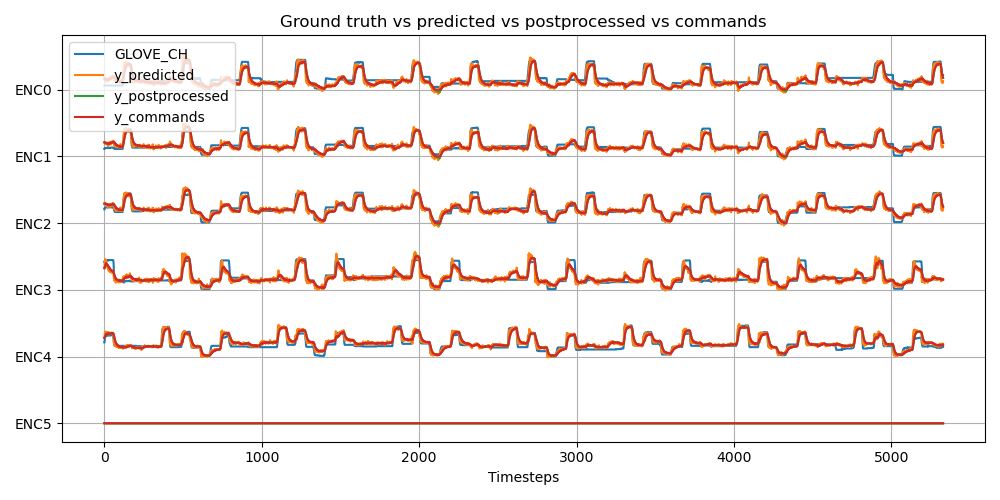

In [22]:
fig = plt.figure(figsize=(10, 5))

lines = []
labels = []

plots = plt.plot(df_sim[GLOVE_CH].values - np.arange(len(GLOVE_CH)) * 200, c='C0')
lines += [plots[0]]
labels += ['GLOVE_CH']

plots = plt.plot(y_dct['y_predicted'] - np.arange(len(GLOVE_CH)) * 200, c='C1')
lines += [plots[0]]
labels += ['y_predicted']

plots = plt.plot(y_dct['y_postprocessed'] - np.arange(len(GLOVE_CH)) * 200, c='C2')
lines += [plots[0]]
labels += ['y_postprocessed']

plots = plt.plot(y_dct['y_commands'] - np.arange(len(GLOVE_CH)) * 200, c='C3')
lines += [plots[0]]
labels += ['y_commands']

plt.title('Ground truth vs predicted vs postprocessed vs commands')
plt.yticks(-np.arange(len(GLOVE_CH)) * 200, GLOVE_CH)
plt.legend(lines, labels)
plt.grid()
plt.xlabel('Timesteps')

plt.tight_layout()

### Online (prosthesis or virtual hand)

In [23]:
TIMEOUT = 0.033
DEBUG = True

ser = None
# ser_port = None
ser_port = '/dev/cu.usbmodem3498365F31351'

if ser_port is not None:
    ser = serial.Serial(port=ser_port, timeout=2*TIMEOUT)
    ser.write('T1#\r\n'.encode('utf-8')) # T1 for Timestamp activate
    ser.write('M2#\r\n'.encode('utf-8')) # M2 for Mode == 2 = send samples
    ser.write('S2#\r\n'.encode('utf-8')) # SYNC to 2 for sanity check

    # flush buffers
    ser.reset_input_buffer()
    ser.read()
    
    i = 0;
    while(ser.in_waiting):
        print(f'Flushing buffers {i}: {ser.in_waiting}', end='    \r')
        ser.read_all()
        time.sleep(0.005)
        i+=1;
    ser.readline()
    ser.readline()
    
i = 0
ts_old = time.time()
ts_diff = 0;

y_previous = None
while True:    
    
    # [Data reading]
    s = ser.readline()
    ts_start = time.time()
    
    try:
        sample = np.array(s.decode('UTF-8')\
                           .replace('\r\n', "")\
                           .split(' ')
                         ).astype(int)
        [omg_sample, acc_sample, enc_sample, [button, sync, ts]] = np.array_split(sample, [50, 56, 62])
        
    except Exception as e:
        print(e)
        
    # [/Data Reading]
        
    # [Data preprocessing]
    sample_preprocessed = preprocessing(omg_sample)
    # [/Data preprocessing]
    
    # [Inference]
    y_predicted         = inference(sample_preprocessed)
    # [/Inference]
    
    # [Inference Postprocessing]
    y_postprocessed     = postprocessing(y_predicted, y_previous)
    # [/Inference Postprocessing]
    
    # [Commands composition]
    y_commands          = commands(y_postprocessed)
    # [/Commands composition]
    
    # [Commands sending]
    pack, _ = drv_abs_one(ser, list(y_commands)); # + [0]
    # [/Commands sending]
    
    y_previous = y_postprocessed
    
    if DEBUG:
        clear_output(wait=True)

        # sanity check: iteration should increase monotonically, TIMEDIFF approximately 32-34 ms, CYCLETIME < TIMEOUT, WAITING should be == 0
        print(f'ITERATION:\t{i}\tTIMEDIFF:\t{(ts_start - ts_old)*1000: .0f}\tCYCLETIME:\t{ts_diff*1000:.0f}\tWAITING:\t{ser.in_waiting}')
        print('INPUT:\n', s)

        # sanity check: Sizes of SAMPLE=65, OMG=50, ACC=6, ENCODERS=6
        print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}, ACC: {len(acc_sample)}, ENCODERS: {len(enc_sample)}')
        print(f'BUTTON: {button}, SYNC: {sync}, TS: {ts}')
        print(y_commands)
        print(pack)
    
    ts_diff = time.time() - ts_start
    assert(ts_diff<TIMEOUT), 'Calculation cycle takes more than TIMEOUT, halting...'
    ts_old = ts_start
    i += 1 

SerialException: [Errno 2] could not open port /dev/cu.usbmodem3498365F31351: [Errno 2] No such file or directory: '/dev/cu.usbmodem3498365F31351'